In [2]:
from numba import njit
from hftbacktest import (
    SingleAssetHftBacktest_,
    HftBacktest,
    FeedLatency,
    SquareProbQueueModel,
    Linear,
    Stat,
    BUY,
    SELL,
    GTX,
    GTC,
    ConstantLatency,
    PartialFillExchange
)
from hftbacktest import COL_EXCH_TIMESTAMP, COL_SIDE, COL_PRICE, COL_QTY
from hftbacktest import COL_EXCH_TIMESTAMP, COL_SIDE, COL_PRICE, COL_QTY
from numba.typed import List
from numba.types import Tuple, float64
import numpy as np

In [3]:
@njit
def simple_two_sided_quote(hbt: SingleAssetHftBacktest_, stat):
    max_position = 10
    half_spread = hbt.tick_size
    skew = 0.01
    order_qty = 1
    last_order_id = -1
    order_id = 0

    # Checks every 0.1s
    while hbt.elapse(100_000):
        # Clears cancelled, filled or expired orders.
        hbt.clear_inactive_orders()

        # Obtains the current mid-price and compute the reservation price.
        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0

        # 
        reservation_price = mid_price - skew * hbt.position * hbt.tick_size
        
        buy_order_price = 150
        sell_order_price = 130
        last_order_id = -1
        # Cancel all outstanding orders
        for order in hbt.orders.values():
            if order.cancellable:
                hbt.cancel(order.order_id)
                last_order_id = order.order_id

        # All order requests are considered to be requested at the same time.
        # Waits until one of the order cancellation responses is received.
        if last_order_id >= 0:
            hbt.wait_order_response(last_order_id)

        # Clears cancelled, filled or expired orders.
        hbt.clear_inactive_orders()

        if hbt.position < max_position:
            # Submits a new post-only limit bid order.
            order_id += 1
            hbt.submit_buy_order(
                order_id,
                buy_order_price,
                order_qty,
                GTC
            )
            last_order_id = order_id

        if hbt.position > -max_position:
            # Submits a new post-only limit ask order.
            order_id += 1
            hbt.submit_sell_order(
                order_id,
                sell_order_price,
                order_qty,
                GTC
            )
            last_order_id = order_id

        # All order requests are considered to be requested at the same time.
        # Waits until one of the order responses is received.
        if last_order_id >= 0:
            hbt.wait_order_response(last_order_id)

        # Records the current state for stat calculation.
        stat.record(hbt)

@njit
def print_trades(hbt):
    while hbt.elapse(60 * 1e6):
        print('-------------------------------------------------------------------------------')
        print('current_timestamp:', hbt.current_timestamp)

        num = 0
        for trade in hbt.last_trades:
            if num > 10:
                print('...')
                break
            print(
                'exch_timestamp:',
                trade[COL_EXCH_TIMESTAMP],
                'buy' if trade[COL_SIDE] == 1 else 'sell',
                trade[COL_QTY],
                '@',
                trade[COL_PRICE]
            )
            num += 1

        hbt.clear_last_trades()
    return True


@njit
def print_3depth(hbt):
    while hbt.elapse(60 * 1e6):
        # a key of bid_depth or ask_depth is price in tick format.
        # (integer) price_tick = price / tick_size
        print('current_timestamp:', hbt.current_timestamp)
        i = 0
        for tick_price in range(hbt.best_ask_tick, hbt.high_ask_tick + 1):
            if tick_price in hbt.ask_depth:
                print(
                    'ask: ',
                    hbt.ask_depth[tick_price],
                    '@',
                    round(tick_price * hbt.tick_size, 3)
                )
                i += 1
                if i == 3:
                    break
        i = 0
        for tick_price in range(hbt.best_bid_tick, hbt.low_bid_tick - 1, -1):
            if tick_price in hbt.bid_depth:
                print(
                    'bid: ',
                    hbt.bid_depth[tick_price],
                    '@',
                    round(tick_price * hbt.tick_size, 3)
                )
                i += 1
                if i == 3:
                    break
    return True

@njit
def orderbookimbalance(hbt, out):
    while hbt.elapse(10 * 1e6):
        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0

        sum_ask_qty_50bp = 0.0
        sum_ask_qty = 0.0
        for tick_price in range(hbt.best_ask_tick, hbt.high_ask_tick + 1):
            if tick_price in hbt.ask_depth:
                ask_price = tick_price * hbt.tick_size
                depth_from_mid = (ask_price - mid_price) / mid_price
                if depth_from_mid > 0.01:
                    break
                sum_ask_qty += hbt.ask_depth[tick_price]

                if depth_from_mid <= 0.005:
                    sum_ask_qty_50bp = sum_ask_qty


        sum_bid_qty_50bp = 0.0
        sum_bid_qty = 0.0
        for tick_price in range(hbt.best_bid_tick, hbt.low_bid_tick - 1, -1):
            if tick_price in hbt.bid_depth:
                bid_price = tick_price * hbt.tick_size
                depth_from_mid = (mid_price - bid_price) / mid_price
                if depth_from_mid > 0.01:
                    break
                sum_bid_qty += hbt.bid_depth[tick_price]

                if depth_from_mid <= 0.005:
                    sum_bid_qty_50bp = sum_bid_qty

        imbalance_50bp = sum_bid_qty_50bp - sum_ask_qty_50bp
        imbalance_1pct = sum_bid_qty - sum_ask_qty
        imbalance_tob = hbt.bid_depth[hbt.best_bid_tick] - hbt.ask_depth[hbt.best_ask_tick]

        out.append((hbt.current_timestamp, imbalance_tob, imbalance_50bp, imbalance_1pct))
    return True


In [4]:
# This backtest assumes market maker rebates.
# https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2023-04-04-01007356e6514df3811b0c80ab8c83bf
    
hbt = HftBacktest(
    [
        "/home/danny/hftbacktest/mbp/GOOG_20231215.npz"
    ],
    tick_size=0.01,
    lot_size=1,
    maker_fee=0,
    taker_fee=0.0,
    order_latency=ConstantLatency(0.0001, 0.0001),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    exchange_model=PartialFillExchange,
    snapshot='/home/danny/hftbacktest/mbp/GOOG_20231214_S.npz'
)

stat = Stat(hbt)

Load /home/danny/hftbacktest/mbp/GOOG_20231215.npz
loaded


In [ ]:
pd.read_parquet("processed/GOOG/dbeq-basic-20231214.mbp-10.parquet")

In [5]:
print_3depth(hbt)

current_timestamp: 1702646469415000
ask:  40.0 @ 90.0
ask:  100.0 @ 98.0
ask:  100.0 @ 103.2
bid:  100.0 @ 145.0
bid:  10.0 @ 140.01
bid:  26.0 @ 139.73
current_timestamp: 1702646529415000
ask:  40.0 @ 90.0
ask:  100.0 @ 98.0
ask:  100.0 @ 103.2
bid:  100.0 @ 145.0
bid:  10.0 @ 140.01
bid:  26.0 @ 139.73
current_timestamp: 1702646589415000
ask:  40.0 @ 90.0
ask:  100.0 @ 98.0
ask:  100.0 @ 103.2
bid:  100.0 @ 145.0
bid:  10.0 @ 140.01
bid:  26.0 @ 139.73
current_timestamp: 1702646649415000
ask:  40.0 @ 90.0
ask:  100.0 @ 98.0
ask:  100.0 @ 103.2
bid:  100.0 @ 145.0
bid:  10.0 @ 140.01
bid:  26.0 @ 139.73
current_timestamp: 1702646709415000
ask:  40.0 @ 90.0
ask:  100.0 @ 98.0
ask:  100.0 @ 103.2
bid:  100.0 @ 145.0
bid:  10.0 @ 140.01
bid:  26.0 @ 139.73
current_timestamp: 1702646769415000
ask:  40.0 @ 90.0
ask:  100.0 @ 98.0
ask:  100.0 @ 103.2
bid:  100.0 @ 145.0
bid:  10.0 @ 140.01
bid:  26.0 @ 139.73
current_timestamp: 1702646829415000
ask:  40.0 @ 90.0
ask:  100.0 @ 98.0
ask:  100

True

Load /home/danny/hftbacktest/mbp/GOOG_20231215.npz
loaded


/home/danny/hftbacktest/hftbacktest/stat.py:310: RuntimeWarning: divide by zero encountered in scalar divide
  rrr = ar / mdd


=========== Summary ===========
Sharpe ratio: 185.1
Sortino ratio: nan
Risk return ratio: -inf
Annualised return: 2376008.51 %
Max. draw down: -0.00 %
The number of trades per day: 279277
Avg. daily trading volume: 279277
Avg. daily trading amount: 32815047
Max leverage: 0.00
Median leverage: 0.00


/home/danny/hftbacktest/hftbacktest/stat.py:342: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ((mid / mid[0] - 1).resample(resample).last() * 100).plot(ax=axs[0], style='grey', alpha=0.5)


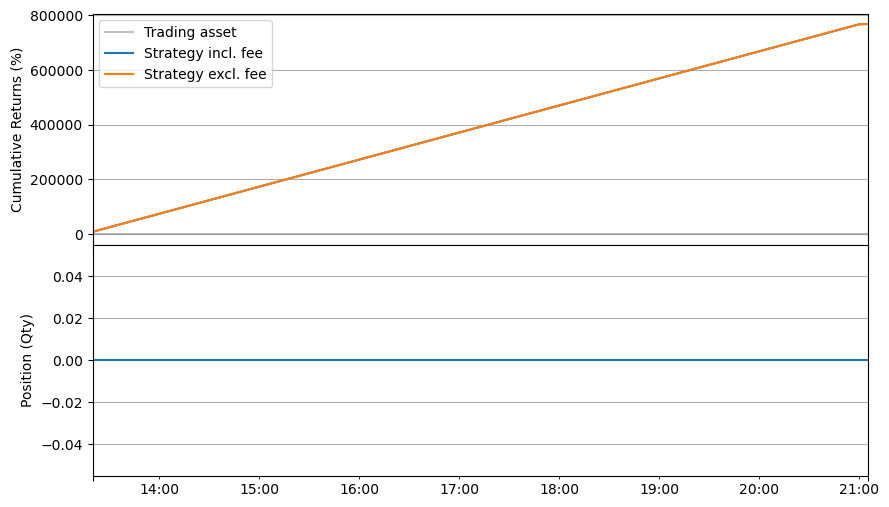

In [6]:

hbt = HftBacktest(
    [
        "/home/danny/hftbacktest/mbp/GOOG_20231215.npz"
    ],
    tick_size=0.01,
    lot_size=1,
    maker_fee=0,
    taker_fee=0.0,
    order_latency=ConstantLatency(0.0001, 0.0001),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    exchange_model=PartialFillExchange,
    snapshot='/home/danny/hftbacktest/mbp/GOOG_20231214_S.npz'
)

stat = Stat(hbt)
simple_two_sided_quote(hbt, stat.recorder)
stat.summary(capital=2000, trading_days=1)

In [7]:
print_trades(hbt)

True

In [8]:


# tup_ty = Tuple((float64, float64, float64, float64))
# out = List.empty_list(tup_ty, allocated=100_000)

# orderbookimbalance(hbt, out)

In [9]:
# import polars as pl

# df = pl.DataFrame(out).transpose()
# df.columns = ['Local Timestamp', 'TOB Imbalance', '0.5% Imbalance', '1% Imbalance']
# df = df.with_columns(
#     pl.from_epoch('Local Timestamp', time_unit='us')
# )

# df

In [10]:
# df["TOB Imbalance"].value_counts()

In [11]:
# def rolling_vwap(hbt, out):
#     buy_amount_bin = np.zeros(100_000, np.float64)
#     buy_qty_bin = np.zeros(100_000, np.float64)
#     sell_amount_bin = np.zeros(100_000, np.float64)
#     sell_qty_bin = np.zeros(100_000, np.float64)

#     idx = 0
#     last_trade_price = np.nan

#     while hbt.elapse(10 * 1e6):
#         for trade in hbt.last_trades:
#             if trade[COL_SIDE] == 1:
#                 buy_amount_bin[idx] += trade[COL_PRICE] * trade[COL_QTY]
#                 buy_qty_bin[idx] += trade[COL_QTY]
#             else:
#                 sell_amount_bin[idx] += trade[COL_PRICE] * trade[COL_QTY]
#                 sell_qty_bin[idx] += trade[COL_QTY]
#         hbt.clear_last_trades()
#         idx += 1

#         if idx >= 1:
#             vwap10sec = np.divide(
#                 buy_amount_bin[idx - 1] + sell_amount_bin[idx - 1],
#                 buy_qty_bin[idx - 1] + sell_qty_bin[idx - 1]
#             )
#         else:
#             vwap10sec = np.nan

#         if idx >= 6:
#             vwap1m = np.divide(
#                 np.sum(buy_amount_bin[idx - 6:idx]) + np.sum(sell_amount_bin[idx - 6:idx]),
#                 np.sum(buy_qty_bin[idx - 6:idx]) + np.sum(sell_qty_bin[idx - 6:idx])
#             )
#             buy_vwap1m = np.divide(np.sum(buy_amount_bin[idx - 6:idx]), np.sum(buy_qty_bin[idx - 6:idx]))
#             sell_vwap1m = np.divide(np.sum(sell_amount_bin[idx - 6:idx]), np.sum(sell_qty_bin[idx - 6:idx]))
#         else:
#             vwap1m = np.nan
#             buy_vwap1m = np.nan
#             sell_vwap1m = np.nan

#         out.append((hbt.current_timestamp, vwap10sec, vwap1m, buy_vwap1m, sell_vwap1m))
#     return True


# tup_ty = Tuple((float64, float64, float64, float64, float64))
# out = List.empty_list(tup_ty, allocated=100_000)
# hbt = HftBacktest(
#     [
#         "/home/danny/hftbacktest/test_dbn1.npz"
#     ],
#     tick_size=0.01,
#     lot_size=1,
#     maker_fee=0,
#     taker_fee=0.0,
#     order_latency=ConstantLatency(0.0001, 0.0001),
#     queue_model=SquareProbQueueModel(),
#     asset_type=Linear,
#     exchange_model=PartialFillExchange,
#     snapshot='/home/danny/hftbacktest/snapshot1.npz'
# )
# rolling_vwap(hbt, out)


In [12]:
# df = pl.DataFrame(out).transpose()
# df.columns = ['Local Timestamp', '10-sec VWAP', '1-min VWAP', '1-min Buy VWAP', '1-min Sell VWAP']
# df = df.with_columns(
#     pl.from_epoch('Local Timestamp', time_unit='us')
# )

# df